<a href="https://colab.research.google.com/github/MoazAshraf/predicting_imdb_ratings/blob/master/predicting_imdb_ratings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Predicting IMDb Ratings for movies, TV shows and games
This solution can be used to develop a movie recommendation system in which movies with higher ratings would have a higher chance of being recommended.

This is a supervised regression problem. [This](https://www.kaggle.com/orgesleka/imdbmovies) public dataset will be used for training and evaluation.

To measure the performance of the system, the root mean squared error will be used as the performance metric. The baseline will be the standard deviation of the movie ratings in the training set as it measures the performance of random guessing.


##Get the Data

In [16]:
import os, stat
from google.colab import files

# upload kaggle.json file
files.upload()  # Upload your kaggle.json file when prompted here

# create the directory
KAGGLE_DIR = '/root/.kaggle'
KAGGLE_FILE_NAME = 'kaggle.json'
if not os.path.isdir(KAGGLE_DIR):
    os.makedirs(KAGGLE_DIR)
kaggle_file_path = os.path.join(KAGGLE_DIR, KAGGLE_FILE_NAME)

# move kaggle file to kaggle directory and set its permissions to be read and written by user only
os.rename(KAGGLE_FILE_NAME, kaggle_file_path)
os.chmod(kaggle_file_path, stat.S_IREAD | stat.S_IWRITE)

Saving kaggle.json to kaggle.json


In [17]:
# download the dataset
!kaggle datasets download -d orgesleka/imdbmovies

imdbmovies.zip: Skipping, found more recently modified local copy (use --force to force download)


In [18]:
# unzip the data
!unzip imdbmovies.zip

Archive:  imdbmovies.zip
replace imdb.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: imdb.csv                


In [0]:
import pandas as pd

# read the data
imdb_data = pd.read_csv('imdb.csv', escapechar='\\')

In [20]:
imdb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14761 entries, 0 to 14760
Data columns (total 44 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   fn                14761 non-null  object 
 1   tid               14761 non-null  object 
 2   title             14761 non-null  object 
 3   wordsInTitle      14748 non-null  object 
 4   url               14761 non-null  object 
 5   imdbRating        13551 non-null  float64
 6   ratingCount       13551 non-null  float64
 7   duration          13745 non-null  float64
 8   year              14731 non-null  float64
 9   type              14761 non-null  object 
 10  nrOfWins          14761 non-null  int64  
 11  nrOfNominations   14761 non-null  int64  
 12  nrOfPhotos        14761 non-null  int64  
 13  nrOfNewsArticles  14761 non-null  int64  
 14  nrOfUserReviews   14761 non-null  int64  
 15  nrOfGenre         14761 non-null  int64  
 16  Action            14761 non-null  int64 

In [0]:
# remove records with missing imdb rating
imdb_data.dropna(subset=['imdbRating'], inplace=True)

In [22]:
imdb_data.shape[0]

13551

In [23]:
imdb_data.describe()

,imdbRating,ratingCount,duration,year,nrOfWins,nrOfNominations,nrOfPhotos,nrOfNewsArticles,nrOfUserReviews,nrOfGenre,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,FilmNoir,GameShow,History,Horror,Music,Musical,Mystery,News,RealityTV,Romance,SciFi,Short,Sport,TalkShow,Thriller,War,Western
count,13551.000000,1.355100e+04,12793.000000,13551.000000,13551.000000,13551.000000,13551.000000,13551.000000,13551.000000,13551.000000,13551.000000,13551.000000,13551.000000,13551.000000,13551.000000,13551.000000,13551.000000,13551.000000,13551.000000,13551.000000,13551.000000,13551.000000,13551.000000,13551.000000,13551.000000,13551.000000,13551.00000,13551.000000,13551.000000,13551.000000,13551.000000,13551.000000,13551.000000,13551.000000,13551.000000,13551.000000,13551.000000,13551.000000
mean,6.865707,2.642480e+04,5626.405378,1989.476496,3.365951,4.914545,25.635377,269.551989,112.456719,2.295107,0.165301,0.001328,0.132610,0.073426,0.044868,0.362630,0.148107,0.075640,0.447495,0.076231,0.061324,0.014021,0.006937,0.041252,0.074312,0.032544,0.02723,0.071877,0.003985,0.006937,0.137702,0.070770,0.034167,0.016899,0.012471,0.096303,0.034831,0.023910
std,1.119515,6.506456e+04,2702.125762,22.302556,9.581572,16.831365,67.742465,1092.792558,236.940988,0.794300,0.371466,0.036423,0.339165,0.260845,0.207021,0.480777,0.355219,0.264431,0.497254,0.265376,0.239932,0.117582,0.083001,0.198879,0.262287,0.177446,0.16276,0.258293,0.063003,0.083001,0.344600,0.256449,0.181665,0.128898,0.110981,0.295017,0.183359,0.152773
min,1.000000,5.000000e+00,2.000000,1888.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.300000,6.025000e+02,4680.000000,1978.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.000000,3.977000e+03,5760.000000,1998.000000,0.000000,0.000000,9.000000,13.000000,37.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.600000,2.085850e+04,6720.000000,2006.000000,3.000000,4.000000,29.000000,120.500000,114.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.900000,1.183395e+06,68400.000000,2014.000000,226.000000,542.000000,2810.000000,32345.000000,4928.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
from sklearn.model_selection import train_test_split

# split the data into a training set and a test set with stratifying to keep the distributions similar
imdb_data['imdbRating_cat'] = pd.cut(imdb_data['imdbRating'], bins=10, labels=range(10))
training_set, test_set = train_test_split(imdb_data, test_size=0.2, stratify=imdb_data['imdbRating_cat'])

In [25]:
print(training_set.shape, test_set.shape)

(10840, 45) (2711, 45)


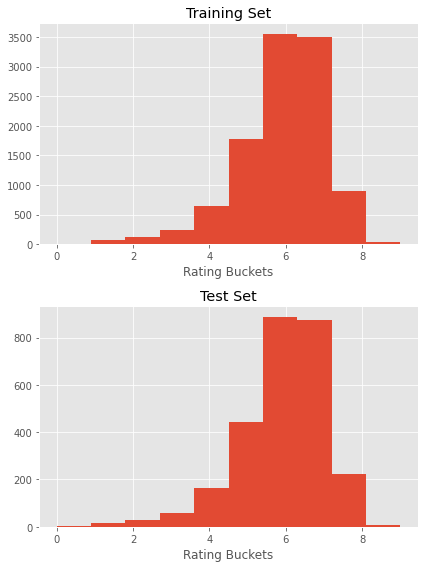

In [26]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
fig = plt.figure(figsize=(6, 8))

plt.subplot(2, 1, 1)
plt.title('Training Set')
training_set['imdbRating_cat'].hist()
plt.xlabel('Rating Buckets')

plt.subplot(2, 1, 2)
plt.title('Test Set')
test_set['imdbRating_cat'].hist()
plt.xlabel('Rating Buckets')

fig.tight_layout()
plt.show()

##Explore the Data

In [0]:
# copy the training set for exploration
imdb_train = training_set.copy()

In [34]:
# find featuers that correlate with the IMDb rating
imdb_train.corr()['imdbRating'].sort_values(ascending=False)

imdbRating          1.000000
nrOfWins            0.190119
Drama               0.179432
ratingCount         0.153482
nrOfNominations     0.126994
History             0.086707
Animation           0.080848
nrOfUserReviews     0.078527
nrOfPhotos          0.075739
nrOfNewsArticles    0.074163
Biography           0.071226
War                 0.070843
Documentary         0.059561
FilmNoir            0.045012
Mystery             0.032309
Crime               0.029292
Music               0.028506
GameShow            0.012306
duration            0.004577
Musical             0.003769
Romance             0.002889
Western             0.001708
nrOfGenre          -0.003384
Sport              -0.009338
Adult              -0.016030
Short              -0.016097
TalkShow           -0.019421
Comedy             -0.023400
RealityTV          -0.029699
Adventure          -0.049375
Family             -0.055734
News               -0.056566
Fantasy            -0.069869
Thriller           -0.072198
SciFi         

[]

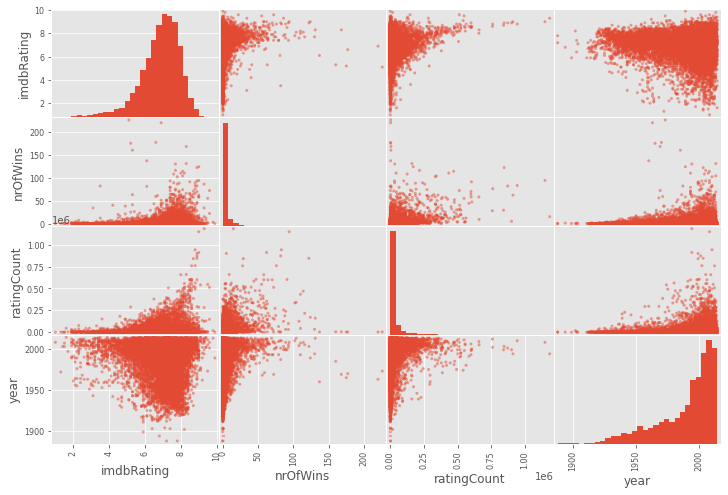

In [80]:
from pandas.plotting import scatter_matrix

# visualize some correlations
features = ['imdbRating', 'nrOfWins', 'ratingCount', 'year']
scatter_matrix(imdb_train[features], figsize=(12, 8), hist_kwds={'bins': 30})
plt.plot()

In [0]:
# adding feature combinations
imdb_train['winsPerNomination'] = imdb_train['nrOfWins'] / (imdb_train['nrOfNominations'] + imdb_train['nrOfWins'])
imdb_train['winsPerNomination'].fillna(0, inplace=True)
imdb_train['reviewsPerRating'] = imdb_train['nrOfUserReviews'] / imdb_train['ratingCount']
imdb_train['reviewsPerRating'].fillna(0, inplace=True)

In [54]:
imdb_train[['winsPerNomination', 'reviewsPerRating']].describe()

,winsPerNomination,reviewsPerRating
count,10840.000000,10840.000000
mean,0.236791,0.012046
std,0.319207,0.018655
min,0.000000,0.000000
25%,0.000000,0.003277
50%,0.000000,0.006677
75%,0.441471,0.013700
max,1.000000,0.333333


In [56]:
imdb_train.corr()['imdbRating'].sort_values(ascending=False)

imdbRating           1.000000
winsPerNomination    0.206947
nrOfWins             0.190119
Drama                0.179432
ratingCount          0.153482
nrOfNominations      0.126994
History              0.086707
Animation            0.080848
nrOfUserReviews      0.078527
nrOfPhotos           0.075739
nrOfNewsArticles     0.074163
Biography            0.071226
War                  0.070843
Documentary          0.059561
FilmNoir             0.045012
Mystery              0.032309
Crime                0.029292
Music                0.028506
GameShow             0.012306
duration             0.004577
Musical              0.003769
Romance              0.002889
Western              0.001708
nrOfGenre           -0.003384
Sport               -0.009338
Adult               -0.016030
Short               -0.016097
TalkShow            -0.019421
Comedy              -0.023400
RealityTV           -0.029699
Adventure           -0.049375
Family              -0.055734
News                -0.056566
Fantasy   

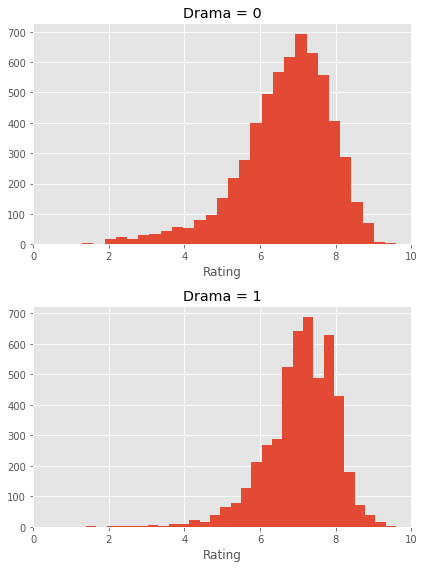

In [78]:
def plot_binary_hists(feature):    
    fig = plt.figure(figsize=(6, 8))

    plt.subplot(2, 1, 1)
    plt.title(f"{feature} = 0")
    plt.xlabel('Rating')
    plt.xlim(0, 10)
    imdb_train[imdb_train[feature]==0]['imdbRating'].hist(bins=30)

    plt.subplot(2, 1, 2)
    plt.title(f"{feature} = 1")
    plt.xlabel('Rating')
    plt.xlim(0, 10)
    imdb_train[imdb_train[feature]==1]['imdbRating'].hist(bins=30)

    fig.tight_layout()

plot_binary_hists('Drama')
plt.show()

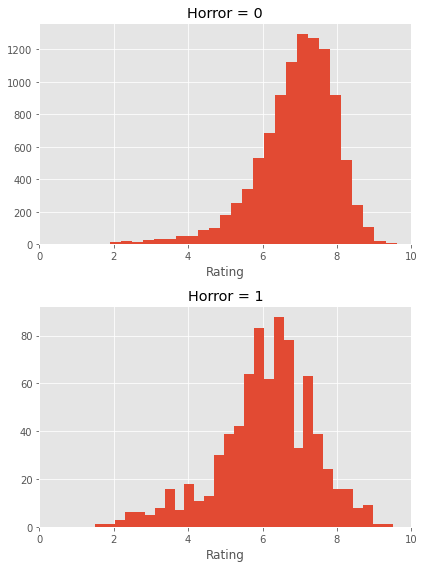

In [79]:
plot_binary_hists('Horror')
plt.show()

In [89]:
print(imdb_data['type'].unique())

['video.movie' 'game' 'video.episode' 'video.tv']


In [87]:
imdb_data[imdb_data['type']=='video.tv'].head()

,fn,tid,title,wordsInTitle,url,imdbRating,ratingCount,duration,year,type,nrOfWins,nrOfNominations,nrOfPhotos,nrOfNewsArticles,nrOfUserReviews,nrOfGenre,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,FilmNoir,GameShow,History,Horror,Music,Musical,Mystery,News,RealityTV,Romance,SciFi,Short,Sport,TalkShow,Thriller,War,Western,imdbRating_cat
609,titles02/index.html.194,tt1103965,The 80th Annual Academy Awards (2008),the th annual academy awards,http://www.imdb.com/title/tt1103965/,6.8,1067.0,11820.0,2008.0,video.tv,1,8,511,6,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6
662,titles02/index.html.2167,tt0051327,Der Kopfgeldjäger (TV Series 1958–1961),der kopfgeldj ger tv series,http://www.imdb.com/title/tt0051327/,8.2,694.0,1800.0,1961.0,video.tv,0,0,13,13,12,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8
1288,titles02/index.html.4313,tt0250182,AFI's 100 Years... 100 Laughs: America's Funni...,afi s years laughs america s funniest movies,http://www.imdb.com/title/tt0250182/,6.4,287.0,NaN,2000.0,video.tv,0,0,0,0,2,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6
1295,titles02/index.html.4347,tt0070644,Szenen einer Ehe (TV Mini-Series 1973),szenen einer ehe tv mini series,http://www.imdb.com/title/tt0070644/,8.4,9187.0,16980.0,1973.0,video.tv,13,2,15,82,39,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
1324,titles02/index.html.4481,tt0043194,Dragnet (TV Series 1951–1959),dragnet tv series,http://www.imdb.com/title/tt0043194/,7.7,661.0,1800.0,1959.0,video.tv,3,12,23,24,16,3,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,7


In [0]:
# TODO: do the previous analysis for each type of media separately (duration might be more useful for movies and episodes)

Notes about the data so far:
- There are 4 types of media: movies, TV shows, TV episodes and games
- Rating positively correlates with the ratio of wins to total nominations
- Rating negatively correlates with the ratio of user reviews to user ratings, people seem to review what they dislike more than what they like
- Rating negatively correlates with the year, it seems old movies are rated better than new movies